### Simple DNN

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
## Change urls 
url_rdf = '/content/drive/My Drive/IBM/dataset/raw_df.csv'
url_pdf = '/content/drive/My Drive/IBM/dataset/processed.csv'
url_udf = '/content/drive/My Drive/IBM/dataset/processed_user.csv'
url_olid = '/content/drive/My Drive/IBM/dataset/olid.csv'
url_hate = '/content/drive/My Drive/IBM/dataset/hate.csv'
rdf = pd.read_csv(url_rdf)
pdf = pd.read_csv(url_pdf)
udf = pd.read_csv(url_udf)
olid = pd.read_csv(url_olid)
hate = pd.read_csv(url_hate)

In [0]:
olid.head()

,Unnamed: 0,tweet,label
0,0,@USER She should ask a few native Americans wh...,1
1,1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,2,Amazon is investigating Chinese employees who ...,0
3,3,"@USER Someone should'veTaken"" this piece of sh...",1
4,4,@USER @USER Obama wanted liberals &amp; illega...,0


In [0]:
## Model Building

In [0]:
from keras.layers import  Dropout, Dense
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [0]:
def TFIDF(X_train, X_test,MAX_NB_WORDS=75000):
    vectorizer_x = TfidfVectorizer(max_features=MAX_NB_WORDS)
    X_train = vectorizer_x.fit_transform(X_train).toarray()
    X_test = vectorizer_x.transform(X_test).toarray()
    print("tf-idf with",str(np.array(X_train).shape[1]),"features")
    return (X_train,X_test)

In [0]:

def Build_Model_DNN_Text(shape, nClasses, dropout=0.5):
    """
    buildModel_DNN_Tex(shape, nClasses,dropout)
    Build Deep neural networks Model for text classification
    Shape is input feature space
    nClasses is number of classes
    """
    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer
    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(nClasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [0]:
def experiment(df):
  
  print("Running Experiment ... ")
  X = df.tweet
  y = df.label
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  print("Generating TFIDF ...")
  X_train_tfidf, X_test_tfidf = TFIDF(X_train, X_test)
  with warnings.catch_warnings():

    warnings.simplefilter("ignore")
    print("Building Model ...")
    model_DNN = Build_Model_DNN_Text(X_train_tfidf.shape[1], 2)
    model_DNN.summary()
    print("\n Starting Training ... \n")
    history = model_DNN.fit(X_train_tfidf, y_train,
                              validation_data=(X_test_tfidf, y_test),
                              epochs=10,
                              batch_size=128,
                              verbose=1)
  
  print("\n Plotting results ... \n")
  plot_graphs(history, 'acc')
  plot_graphs(history, 'loss')
  print("\n Evaluating Model ... \n")
  predicted = model_DNN.predict_classes(X_test_tfidf)
  #print(predicted)
  print(metrics.classification_report(y_test, predicted))
  print("\n")
  logger = logging.getLogger("logger")
  result = compute_metrics(y_test, predicted)
  for key in (result.keys()):
      logger.info("  %s = %s", key, str(result[key]))

In [0]:
def class_balance(df, target):
  cls = df[target].value_counts()
  cls.plot(kind='bar')
  plt.show()

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [0]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

### Experiment with RDF

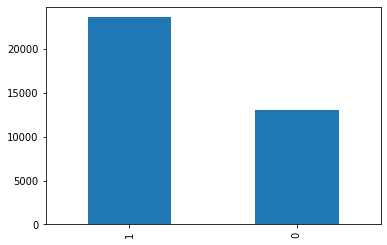

In [0]:
class_balance(rdf,'label')

In [0]:
srdf = shuffle(rdf)

Running Experiment ... 
Generating TFIDF ...
tf-idf with 39054 features
Building Model ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               19996160  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_____________________________

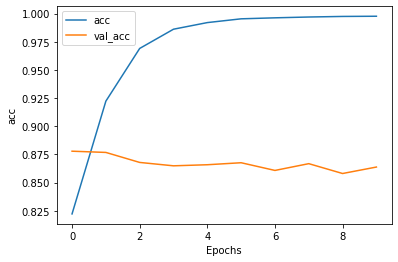

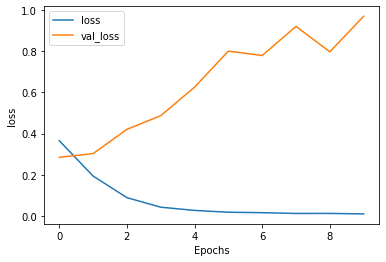


 Evaluating Model ... 



INFO:logger:  mcc = 0.7133546416014355
INFO:logger:  tp = 4028
INFO:logger:  tn = 2294
INFO:logger:  fp = 380
INFO:logger:  fn = 617
INFO:logger:  pricision = 0.9137931034482759
INFO:logger:  recall = 0.8671689989235737
INFO:logger:  F1 = 0.8898707610736772
INFO:logger:  accuracy = 0.8637792048094002


              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2674
           1       0.91      0.87      0.89      4645

    accuracy                           0.86      7319
   macro avg       0.85      0.86      0.86      7319
weighted avg       0.87      0.86      0.86      7319





In [0]:
experiment(srdf)

### Experiment with PDF

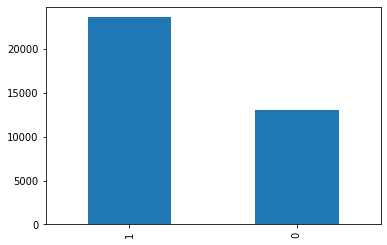

In [0]:
class_balance(pdf,'label')

In [0]:
spdf = shuffle(pdf)

Running Experiment ... 
Generating TFIDF ...
tf-idf with 39559 features
Building Model ...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               20254720  
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_____________________________

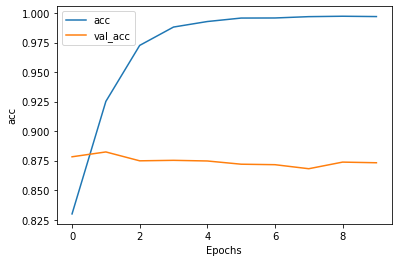

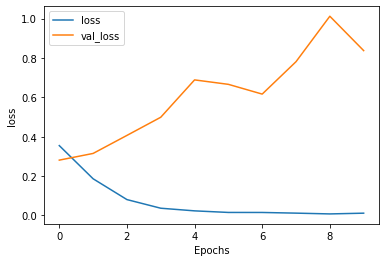


 Evaluating Model ... 



INFO:logger:  mcc = 0.7356550648708308
INFO:logger:  tp = 4087
INFO:logger:  tn = 2304
INFO:logger:  fp = 274
INFO:logger:  fn = 654
INFO:logger:  pricision = 0.9371703737674846
INFO:logger:  recall = 0.8620544188989665
INFO:logger:  F1 = 0.8980443858492639
INFO:logger:  accuracy = 0.8732067222298128


              precision    recall  f1-score   support

           0       0.78      0.89      0.83      2578
           1       0.94      0.86      0.90      4741

    accuracy                           0.87      7319
   macro avg       0.86      0.88      0.87      7319
weighted avg       0.88      0.87      0.87      7319





In [0]:
experiment(spdf)

### Experiment with OLID

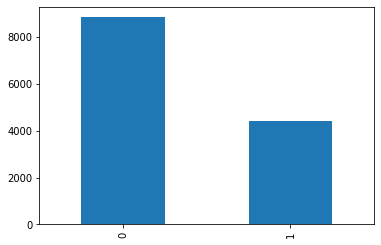

In [0]:
class_balance(olid,'label')

In [0]:
solid = shuffle(olid)

Running Experiment ... 
Generating TFIDF ...
tf-idf with 17087 features
Building Model ...



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               8749056   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10592 samples, validate on 2648 samples
Epoch 1/10



10592/10592 [==============================] - 11s 1ms/step - loss: 0.6096 - acc: 0.6735 - val_loss: 0.5633 - val_acc: 0.7368
Epoch 2/10
10592/10592 [==============================] - 2s 148us/step - loss: 0.4092 - acc: 0.8217 - val_loss: 0.5754 - val_acc: 0.7349
Epoch 3/10
10592/10592 [==============================] - 2s 145us/step - loss: 0.1920 - acc: 0.9309 - val_loss: 0.7089 - val_acc: 0.7277
Epoch 4/10
10592/10592 [==============================] - 2s 145us/step - loss: 0.0736 - acc: 0.9780 - val_loss: 1.1047 - val_acc: 0.6979
Epoch 5/10
10592/10592 [==============================] - 2s 148us/step - loss: 0.0448 - acc: 0.9874 - val_loss: 0.9411 - val_acc: 0.7236
Epoch 6/10
10592/10592 [==============================] - 2s 147us/step - loss: 0.0297 - acc: 0.9921 - val_loss: 1.0236 - val_acc: 0.7338
Epoch 7/10
10592/10592 [==============================] - 2s 148us/step - loss: 0.0215 - acc: 0.9944 - val_loss: 1.2386 - val_acc: 0.7277
Epoch 8/10
10592/10592 [======================

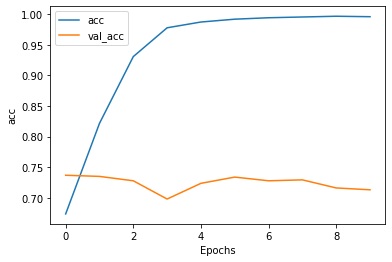

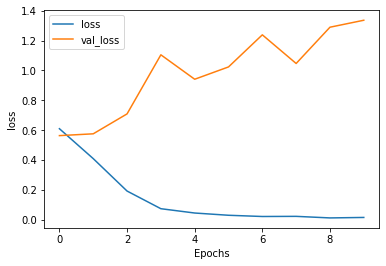


 Evaluating Model ... 



INFO:logger:  mcc = 0.37203539717220674
INFO:logger:  tp = 548
INFO:logger:  tn = 1340
INFO:logger:  fp = 432
INFO:logger:  fn = 328
INFO:logger:  pricision = 0.5591836734693878
INFO:logger:  recall = 0.6255707762557078
INFO:logger:  F1 = 0.5905172413793103
INFO:logger:  accuracy = 0.7129909365558912


              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1772
           1       0.56      0.63      0.59       876

    accuracy                           0.71      2648
   macro avg       0.68      0.69      0.68      2648
weighted avg       0.72      0.71      0.72      2648





In [0]:
experiment(olid)

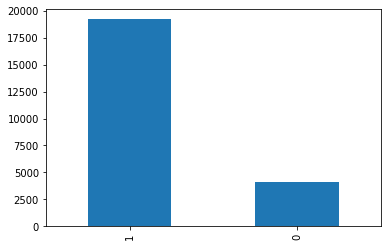

In [0]:
class_balance(hate, 'label')

In [0]:
shate = shuffle(hate)

Running Experiment ... 
Generating TFIDF ...
tf-idf with 29749 features
Building Model ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               15232000  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_____________________________

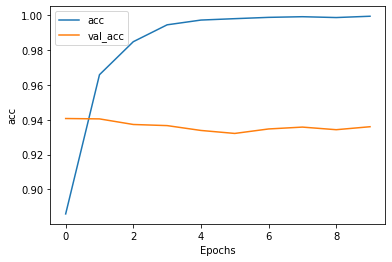

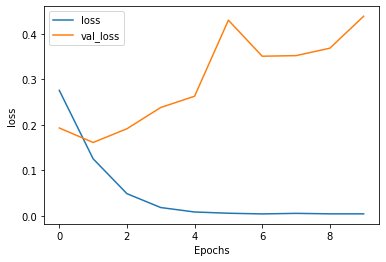


 Evaluating Model ... 



INFO:logger:  mcc = 0.7814785601794518
INFO:logger:  tp = 3689
INFO:logger:  tn = 683
INFO:logger:  fp = 147
INFO:logger:  fn = 152
INFO:logger:  pricision = 0.9616788321167883
INFO:logger:  recall = 0.9604269721426711
INFO:logger:  F1 = 0.9610524944639833
INFO:logger:  accuracy = 0.9359880111325198


              precision    recall  f1-score   support

           0       0.82      0.82      0.82       830
           1       0.96      0.96      0.96      3841

    accuracy                           0.94      4671
   macro avg       0.89      0.89      0.89      4671
weighted avg       0.94      0.94      0.94      4671





In [0]:
experiment(shate)